In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from glob import glob

# Tricking your cerebellum with a reaching task
# Exercise 2 – Savings, generalization & interference

By: Robin Uhrich* and Ieva Kerseviciute*

*equal contribution

## Task 1: Implementation of recording mode and new experiment

### Savings - capturing a baseline

The experimental flow is as follows:

- 20 attempts without perturbation (0-20)
- 60 attempts with perturbation (20-80)
- 20 attempts without perturbation (80-100)
- 60 attempts with perturbation (100-160)
- 20 attempts without perturbation (160-180)

Perturbation of 30 degrees is performed.

This part does not include any additional implementations (task 4).

```{python}
...

PERTURBATION_ANGLE = 30

...

ATTEMPTS_LIMIT = 180

...
    # Design experiment
    if attempts == 1:
        perturbation_mode = False
    elif attempts == 20:
        perturbation_mode = True
        perturbation_type = "sudden"
    elif attempts == 80:
        perturbation_mode = False
    elif attempts == 100:
        perturbation_mode = True
        perturbation_type = "sudden"
    elif attempts == 160:
        perturbation_mode = False
    elif attempts >= ATTEMPTS_LIMIT:
        running = False
...
```

### Group A: Generalization

The experiment is performed in 5 blocks. Each block contains 3 stages, 100 attempts total:

- 20 attempts without perturbation
- 60 attempts with perturbation
- 20 attempts without perturbation

In each part, the target is shifted to a new location:

1. -15 degrees (30 degree perturbation)
2. -75 degrees (30 degree perturbation)
3. -45 degrees (30 degree perturbation)
4. -120 degrees (30 degree perturbation)
5. -120 degrees (-30 degree perturbation)

In this part, we include an additional experiment: the 5th block, in which the perturbation angle is reversed.

```{python}
...

# List the target starting angles here
TARGET_ANGLES = [-15, -75, (-75 - 15) / 2, -120]

PERTURBATION_ANGLE = 30

...

# Setup for blocks
n_perturbation = 60
n_no_perturbation = 20
block_len = n_no_perturbation + n_perturbation + n_no_perturbation

block1_start = 0
block2_start = block_len
block3_start = block_len * 2
block4_start = block_len * 3
block5_start = block_len * 4

ATTEMPTS_LIMIT = block_len * 5

...

    # Design experiment

    # A single block:
    #   - 20 attempts without perturbation
    #   - 60 attempts with perturbation
    #   - 20 attempts without perturbation

    # Block 1
    if attempts == block1_start:
        START_ANGLE = TARGET_ANGLES[0]
        start_target = math.radians(START_ANGLE)
        perturbation_mode = False
    elif attempts == block1_start + n_no_perturbation:
        perturbation_mode = True
        perturbation_type = "sudden"
    elif attempts == block1_start + n_no_perturbation + n_perturbation:
        perturbation_mode = False

    # Block 2
    elif attempts == block2_start:
        START_ANGLE = TARGET_ANGLES[1]
        start_target = math.radians(START_ANGLE)
        perturbation_mode = False
    elif attempts == block2_start + n_no_perturbation:
        perturbation_mode = True
        perturbation_type = "sudden"
    elif attempts == block2_start + n_no_perturbation + n_perturbation:
        perturbation_mode = False

    # Block 3
    elif attempts == block3_start:
        START_ANGLE = TARGET_ANGLES[2]
        start_target = math.radians(START_ANGLE)
        perturbation_mode = False
    elif attempts == block3_start + n_no_perturbation:
        perturbation_mode = True
        perturbation_type = "sudden"
    elif attempts == block3_start + n_no_perturbation + n_perturbation:
        perturbation_mode = False

    # Block 4
    elif attempts == block4_start:
        START_ANGLE = TARGET_ANGLES[3]
        start_target = math.radians(START_ANGLE)
        perturbation_mode = False
    elif attempts == block4_start + n_no_perturbation:
        perturbation_mode = True
        perturbation_type = "sudden"
    elif attempts == block4_start + n_no_perturbation + n_perturbation:
        perturbation_mode = False

    # Block 5: repeat block 4 with perturbation angle in the opposite direction
    if attempts == block5_start:
        START_ANGLE = TARGET_ANGLES[3]
        start_target = math.radians(START_ANGLE)
        perturbation_mode = False
    elif attempts == block5_start + n_no_perturbation:
        # Reverse perturbation angle
        perturbation_angle = -perturbation_angle
        perturbation_mode = True
        perturbation_type = "sudden"
    elif attempts == block5_start + n_no_perturbation + n_perturbation:
        perturbation_mode = False

    # End
    elif attempts >= ATTEMPTS_LIMIT:
        running = False

...
```

## Task 2: Analysis of experiment on unbiased subjects

### Savings

In [2]:
experiment = pd.DataFrame({
    "Attempt": [1, 20, 80, 100, 160],
    "AttemptEnd": np.array([20, 80, 100, 160, 180]) - 1,
    "Perturbation": [
        "No perturbation", "Sudden",
        "No perturbation", "Sudden",
        "No perturbation"
    ]
})

n_attempts = 180

attempts = list(range(1, n_attempts + 1))

perturbations = []
for i in range(len(experiment)):
    start = experiment["Attempt"][i]
    end = experiment["Attempt"][i + 1] if i + 1 < len(experiment) else n_attempts + 1
    perturbations.extend([experiment["Perturbation"][i]] * (end - start))

full_experiment = pd.DataFrame({ "Attempt": attempts, "Perturbation": perturbations })

In [3]:
def read_data(filename):
    res = np.load(filename, allow_pickle = True)
    return pd.DataFrame({
        "MoveFaster": res.item()["move_faster_logs"],
        "ErrorAngle": res.item()["error_angle_logs"],
        "Time": res.item()["time_logs"],
        "Attempt": np.arange(len(res.item()["move_faster_logs"])) + 1
    })


def preprocess(data, design):
    # Merge with experimental design describing perturbation conditions
    data = pd.merge(data, design)

    # Remove trials where move faster appeared
    data = data[data.MoveFaster == 0]
    data.reset_index(drop = True, inplace = True)

    return data


def evaluate_statistics(data):
    statistics = []

    for _, change in experiment.iterrows():
        selected_data = data[(data.Attempt >= change.Attempt) & (data.Attempt <= change.AttemptEnd)]
        error_angle = selected_data.ErrorAngle.to_numpy()
        error_angle = error_angle[~selected_data.MoveFaster.to_numpy().astype(bool)]

        statistics.append(pd.DataFrame({
            "Perturbation": change.Perturbation,
            "ErrorAngleStd": [error_angle.std()],
            "ErrorAngleMean": [error_angle.mean()],
            "TimeStd": [selected_data.Time.std()],
            "TimeMean": [selected_data.Time.mean()]
        }))

    statistics = pd.concat(statistics, ignore_index = True)

    return statistics

In [4]:
def plot_error_angle(subjects, experiment, prefix = "Trial", ylim = None):
    fig, axs = plt.subplots(nrows = 1, ncols = 1, figsize = (7, 4))

    color_map = mpl.colormaps["autumn"]
    n_colors = len(experiment.Perturbation.unique())
    colors = [color_map(idx / (n_colors - 1)) for idx in range(n_colors)]
    colors = dict(zip(experiment.Perturbation.unique(), colors))
    unique_periods = experiment.Perturbation.unique()

    # Show the different experimental periods
    for i, change in experiment.iterrows():
        label = change.Perturbation if change.Perturbation in unique_periods else ""
        unique_periods = unique_periods[unique_periods != change.Perturbation]

        start = change.Attempt
        end = change.AttemptEnd

        axs.axvspan(
            start, end,
            alpha = 0.2,
            label = label,
            color = colors.get(change.Perturbation)
        )

    for i, subject in enumerate(subjects):
        error_angle: np.ndarray = subject.ErrorAngle.to_numpy()
        error_angle[subject.MoveFaster.to_numpy().astype(bool)] = np.nan
        axs.plot(
            subject.Attempt,
            error_angle,
            linewidth = 1,
            label = f"{prefix} {i + 1}"
        )
    
    if ylim is not None:
        axs.set_ylim(-ylim, ylim)

    axs.set_ylabel("Error angle (degrees)")
    axs.set_xlabel("Attempt")
    axs.legend(loc = "center left", bbox_to_anchor = (1, 0.5))
    axs.set_title("Error angle over attempts")

    # Remove the suptitle from boxplot
    plt.suptitle("")

    fig.tight_layout()

In [5]:
# List of all subjects
subject = [preprocess(read_data(file), full_experiment) for file in ["Irene_savings_1.npy", "Irene_savings_2.npy"]]

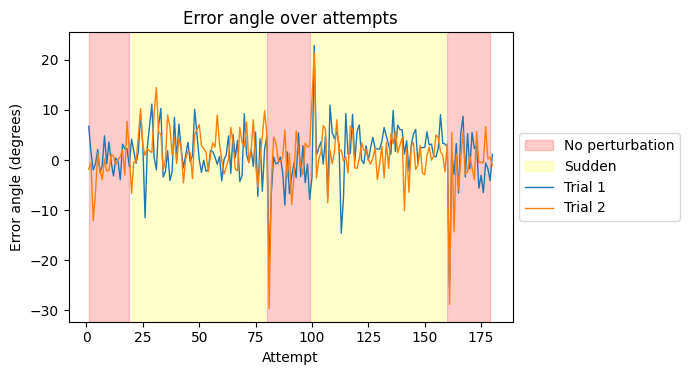

In [6]:
plot_error_angle(subject, experiment)

**Figure 1.** Error angles throughout the experiment 1, marking the experimental blocks. The curves correspond to the 2 trials of the same subject.

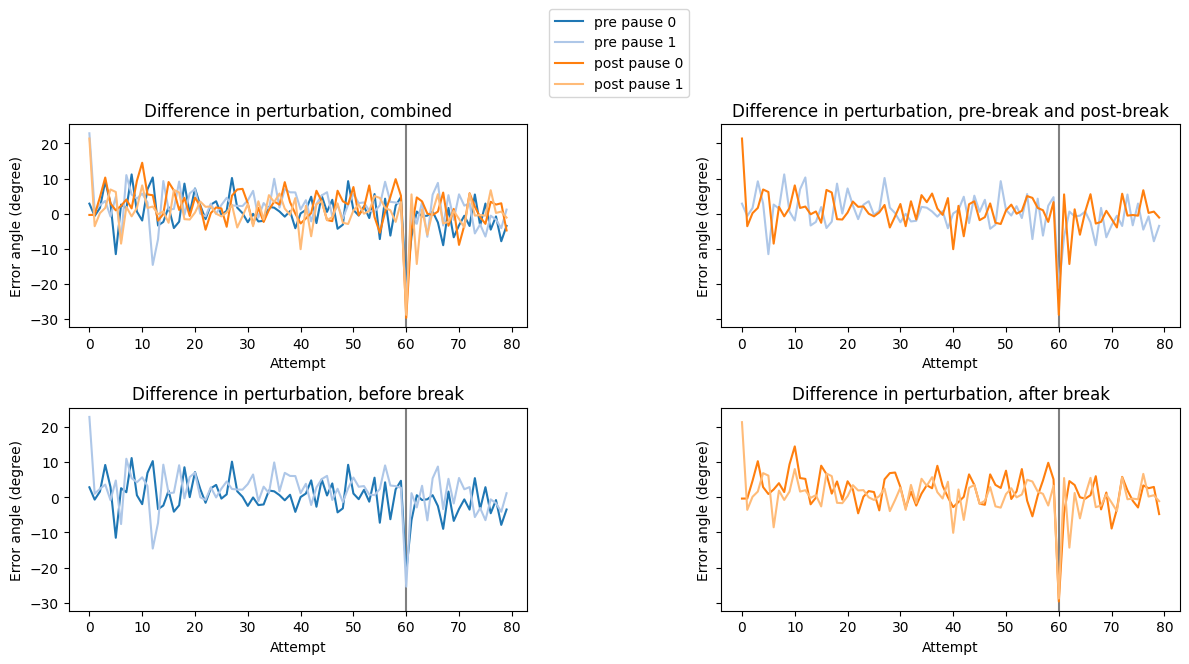

In [7]:
def _load_df(path: str) -> pd.DataFrame:
    content = np.load(path, allow_pickle = True).item()
    df = {
        "move_faster_logs": content["move_faster_logs"],
        "error_angle_logs": content["error_angle_logs"],
    }
    df = pd.DataFrame(df)
    df["attempt"] = np.arange(len(df))
    return df


def load_saving_data():
    data = []
    files = glob("*_savings_*.npy")
    pre_pause = list(filter(lambda x: x[-5] == "1", files))
    post_pause = [ele for ele in files if ele not in pre_pause]
    pre_pause = sorted(pre_pause)
    post_pause = sorted(post_pause)
    for idx, file in enumerate(pre_pause):
        df = _load_df(file)
        df["subject"] = idx
        df["pre_pose"] = True
        data.append(df)
    for idx, file in enumerate(post_pause):
        df = _load_df(file)
        df["subject"] = idx
        df["pre_pose"] = False
        data.append(df)

    df = pd.concat(data)
    return df

df = load_saving_data()

fig, axs = plt.subplots(ncols = 2, nrows = 2, sharey = True, figsize = (12, 7))
cmap = mpl.colormaps["tab20"]

pre_pause = df[df["pre_pose"]]
post_pause = df[df["pre_pose"] == False]

ax = axs[0, 0]
ax.axvline(60, color = "grey")
splits = np.split(pre_pause["error_angle_logs"].to_numpy(), [20, 100])
ax.plot(splits[1], color = cmap(0), label = "pre pause 0")
ax.plot(splits[2], color = cmap(1), label = "pre pause 1")

splits = np.split(post_pause["error_angle_logs"].to_numpy(), [20, 100])
ax.plot(splits[1], color = cmap(2), label = "post pause 0")
ax.plot(splits[2], color = cmap(3), label = "post pause 1")

ax.set_ylabel("Error angle (degree)")
ax.set_xlabel("Attempt")
ax.legend(loc = "upper center", bbox_to_anchor = (1.2, 1.6))
ax.set_title("Difference in perturbation, combined")

ax = axs[0, 1]
ax.axvline(60, color = "grey")
splits1 = np.split(pre_pause["error_angle_logs"].to_numpy(), [20, 100])
splits2 = np.split(post_pause["error_angle_logs"].to_numpy(), [20, 100])
ax.plot(splits1[1], color = cmap(1), label = "pre pause 1")
ax.plot(splits2[2], color = cmap(2), label = "post pause 0")
ax.set_title("Difference in perturbation, pre-break and post-break")
ax.set_ylabel("Error angle (degree)")
ax.set_xlabel("Attempt")

ax = axs[1, 0]
ax.axvline(60, color = "grey")
splits = np.split(pre_pause["error_angle_logs"].to_numpy(), [20, 100])
ax.plot(splits[1], color = cmap(0), label = "pre pause 0")
ax.plot(splits[2], color = cmap(1), label = "pre pause 1")
ax.set_title("Difference in perturbation, before break")
ax.set_ylabel("Error angle (degree)")
ax.set_xlabel("Attempt")

ax = axs[1, 1]
ax.axvline(60, color = "grey")
splits = np.split(post_pause["error_angle_logs"].to_numpy(), [20, 100])
ax.plot(splits[1], color = cmap(2), label = "post pause 0")
ax.plot(splits[2], color = cmap(3), label = "post pause 1")
ax.set_title("Difference in perturbation, after break")
ax.set_ylabel("Error angle (degree)")
ax.set_xlabel("Attempt")

fig.tight_layout()
plt.show()

**Figure 2.** Error angles comparing the perturbation blocks before (blue) and after (orange) the break. The gray line marks the end of the perturbation attempts. (Top left) Combined perturbation blocks. (Top right) Last perturbation before the break and first perturbation after the break. (Bottom left) Perturbation blocks before the break. (Bottom right) Perturbation blocks after the break.

### Group A

In [8]:
experiment = pd.DataFrame({
    "Attempt": [1, 20, 80, 100, 120, 180, 200, 220, 280, 300, 320, 380, 400, 420, 480],
    "AttemptEnd": np.array([20, 80, 100, 120, 180, 200, 220, 280, 300, 320, 380, 400, 420, 480, 500]) - 1,
    "Perturbation": [
        "No perturbation", "Sudden 30° (-15)", "No perturbation",
        "No perturbation", "Sudden 30° (-75)", "No perturbation",
        "No perturbation", "Sudden 30° (-45)", "No perturbation",
        "No perturbation", "Sudden 30° (-120)", "No perturbation",
        "No perturbation", "Sudden -30° (-120)", "No perturbation"
    ]
})

n_attempts = 500

attempts = list(range(1, n_attempts + 1))

perturbations = []
for i in range(len(experiment)):
    start = experiment["Attempt"][i]
    end = experiment["Attempt"][i + 1] if i + 1 < len(experiment) else n_attempts + 1
    perturbations.extend([experiment["Perturbation"][i]] * (end - start))

full_experiment = pd.DataFrame({ "Attempt": attempts, "Perturbation": perturbations })

In [9]:
# List of all subjects
subject = [preprocess(read_data(file), full_experiment) for file in ["Irene_group_A.npy"]]

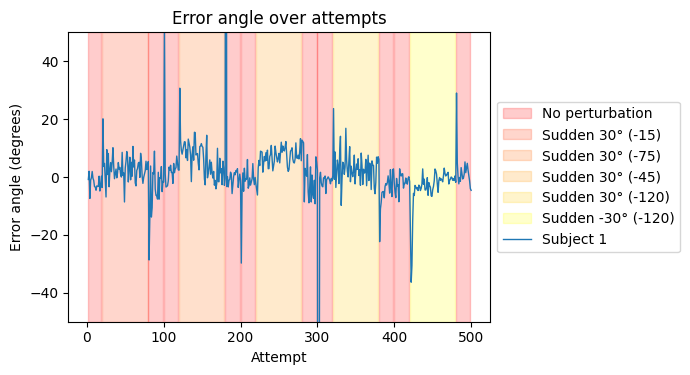

In [10]:
plot_error_angle(subject, experiment, prefix = "Subject", ylim = 50)

**Figure 3.** Error angles throughout the experiment 2, marking the experimental blocks. Error angles are cut off at 50 degrees (the subject made large errors when the target angle changed, at attempts 100, 200 and 300).

In [176]:
subject = read_data("Irene_group_A.npy")
subject = pd.merge(subject, full_experiment)

trial_start = subject[ subject.Perturbation == "Sudden 30° (-15)" ].Attempt.min()
perturbed = subject[ (subject.Attempt > trial_start) & (subject.Attempt < trial_start + 80) ]

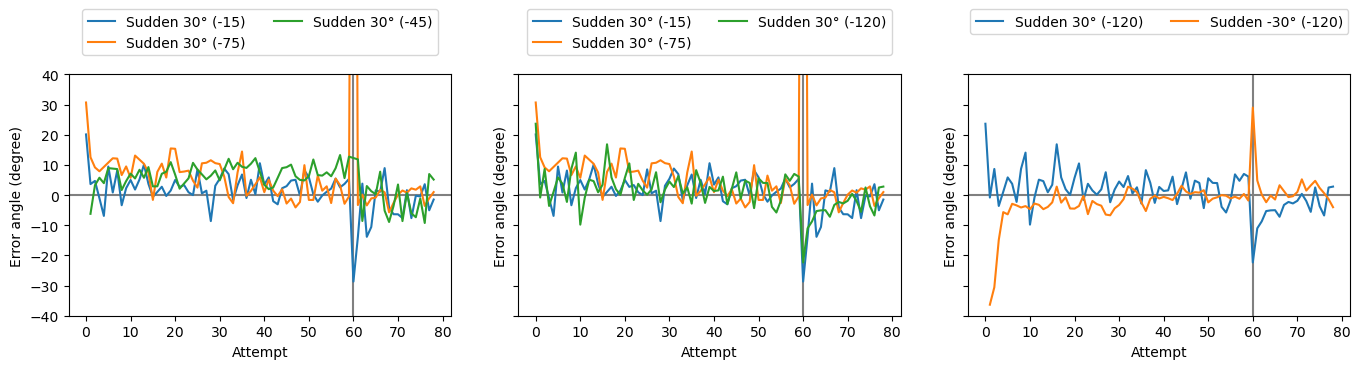

In [188]:
fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize = (14, 4), sharey=True)

subject = read_data("Irene_group_A.npy")
subject = pd.merge(subject, full_experiment)

axs[0].axvline(60, color = "grey")
axs[1].axvline(60, color = "grey")
axs[2].axvline(60, color = "grey")

######## 1st plot

trial_start = subject[ subject.Perturbation == "Sudden 30° (-15)" ].Attempt.min()
perturbed = subject[ (subject.Attempt > trial_start) & (subject.Attempt < trial_start + 80) ].copy()

perturbed.reset_index(drop = True, inplace = True)
perturbed["Attempt"] = np.arange(len(perturbed))

perturbed = perturbed[ perturbed.MoveFaster == 0 ]

axs[0].axhline(0, color="grey")
axs[0].plot(
    perturbed.Attempt, perturbed.ErrorAngle,
    label = "Sudden 30° (-15)"
)

trial_start = subject[ subject.Perturbation == "Sudden 30° (-75)" ].Attempt.min()
perturbed = subject[ (subject.Attempt > trial_start) & (subject.Attempt < trial_start + 80) ].copy()

perturbed.reset_index(drop = True, inplace = True)
perturbed["Attempt"] = np.arange(len(perturbed))

perturbed = perturbed[ perturbed.MoveFaster == 0 ]

axs[0].plot(
    perturbed.Attempt, perturbed.ErrorAngle,
    label = "Sudden 30° (-75)"
)

trial_start = subject[ subject.Perturbation == "Sudden 30° (-45)" ].Attempt.min()
perturbed = subject[ (subject.Attempt > trial_start) & (subject.Attempt < trial_start + 80) ].copy()

perturbed.reset_index(drop = True, inplace = True)
perturbed["Attempt"] = np.arange(len(perturbed))

perturbed = perturbed[ perturbed.MoveFaster == 0 ]

axs[0].plot(
    perturbed.Attempt, perturbed.ErrorAngle,
    label = "Sudden 30° (-45)"
)

axs[0].set_ylabel("Error angle (degree)")
axs[0].set_xlabel("Attempt")

axs[0].legend(loc = "upper center", bbox_to_anchor = (0.5, 1.3), ncol = 2)

######## 2nd plot

trial_start = subject[ subject.Perturbation == "Sudden 30° (-15)" ].Attempt.min()
perturbed = subject[ (subject.Attempt > trial_start) & (subject.Attempt < trial_start + 80) ].copy()

perturbed.reset_index(drop = True, inplace = True)
perturbed["Attempt"] = np.arange(len(perturbed))

perturbed = perturbed[ perturbed.MoveFaster == 0 ]

axs[1].axhline(0, color="grey")
axs[1].plot(
    perturbed.Attempt, perturbed.ErrorAngle,
    label = "Sudden 30° (-15)"
)

trial_start = subject[ subject.Perturbation == "Sudden 30° (-75)" ].Attempt.min()
perturbed = subject[ (subject.Attempt > trial_start) & (subject.Attempt < trial_start + 80) ].copy()

perturbed.reset_index(drop = True, inplace = True)
perturbed["Attempt"] = np.arange(len(perturbed))

perturbed = perturbed[ perturbed.MoveFaster == 0 ]

axs[1].plot(
    perturbed.Attempt, perturbed.ErrorAngle,
    label = "Sudden 30° (-75)"
)

trial_start = subject[ subject.Perturbation == "Sudden 30° (-120)" ].Attempt.min()
perturbed = subject[ (subject.Attempt > trial_start) & (subject.Attempt < trial_start + 80) ].copy()

perturbed.reset_index(drop = True, inplace = True)
perturbed["Attempt"] = np.arange(len(perturbed))

perturbed = perturbed[ perturbed.MoveFaster == 0 ]

axs[1].plot(
    perturbed.Attempt, perturbed.ErrorAngle,
    label = "Sudden 30° (-120)"
)

axs[1].set_ylabel("Error angle (degree)")
axs[1].set_xlabel("Attempt")

axs[1].set_ylim(-40, 40)

axs[1].legend(loc = "upper center", bbox_to_anchor = (0.5, 1.3), ncol = 2)


######## 3rd plot

trial_start = subject[ subject.Perturbation == "Sudden 30° (-120)" ].Attempt.min()
perturbed = subject[ (subject.Attempt > trial_start) & (subject.Attempt < trial_start + 80) ].copy()

perturbed.reset_index(drop = True, inplace = True)
perturbed["Attempt"] = np.arange(len(perturbed))

perturbed = perturbed[ perturbed.MoveFaster == 0 ]

axs[2].axhline(0, color="grey")
axs[2].plot(
    perturbed.Attempt, perturbed.ErrorAngle,
    label = "Sudden 30° (-120)"
)

trial_start = subject[ subject.Perturbation == "Sudden -30° (-120)" ].Attempt.min()
perturbed = subject[ (subject.Attempt > trial_start) & (subject.Attempt < trial_start + 80) ].copy()

perturbed.reset_index(drop = True, inplace = True)
perturbed["Attempt"] = np.arange(len(perturbed))

perturbed = perturbed[ perturbed.MoveFaster == 0 ]

axs[2].plot(
    perturbed.Attempt, perturbed.ErrorAngle,
    label = "Sudden -30° (-120)"
)

axs[2].set_ylabel("Error angle (degree)")
axs[2].set_xlabel("Attempt")

axs[2].legend(loc = "upper center", bbox_to_anchor = (0.5, 1.3), ncol = 2)

fig.tight_layout()
plt.show()

**Figure 4.** Error angles during perturbed segments of the experiment. The gray line (at 60 attempts) marks the end of the perturbation attempts. (Left) Results of the initial angle (-15 degrees), larger angle (-75 degrees), and middle angle (-45 degrees). (Middle) Results of the initial angle (-15 degrees), larger angle (-75 degrees), and the largest angle (-120 degrees). (Right) Results of the largest angle (-120 degrees), comparing the initial perturbation (30 degrees) and reversed perturbation (-30 degrees).

What is particular interesting for this experiment is the initial reaction of the subject to the perturbation. The initial spike in te left plot for -75 degree is most extreme as expected. But comparing this to the -45 degrees which has a higher perturbation than -15 degrees but has a lower error angle in the beginning. This could either mean we were lucky (what is quite possible) or the subject is able to interpolate between the perturbations and with respect to the middle plot also able to generalize a bit because the -120 degrees did not have this large of a spike than -75 degrees. 

Further while looking into our own experiment (Right) the subject has and even larger error angle when the perturbation direction is reversed.

## Task 3: Discussion of your results

• Is there any motor adaptation left after 30 minutes? (all)

Our subject did not exhibit motor adaptation after the break. Quite the opposite - the absolute error angle was actually larger than in the 1st trial, with larger angle standard deviation. Same follows for the 2nd perturbation block within the same trial. This can be seen in Figure 2 (and the statistics below).


In [189]:
splits1 = np.split(pre_pause["error_angle_logs"].to_numpy(), [20, 80])
splits2 = np.split(post_pause["error_angle_logs"].to_numpy(), [20, 80])

print(f"Absolute error angle (1st trial, 1st perturbation block): {abs(round(np.mean(splits1[0]), 2))} +- {round(np.std(splits1[0]), 2)} (SD) degrees")
print(f"Absolute error angle (1st trial, 2nd perturbation block): {abs(round(np.mean(splits1[1]), 2))} +- {round(np.std(splits1[1]), 2)} (SD) degrees")

print(f"Absolute error angle (2nd trial, 1st perturbation block): {abs(round(np.mean(splits2[0]), 2))} +- {round(np.std(splits2[0]), 2)} (SD) degrees")
print(f"Absolute error angle (2nd trial, 2nd perturbation block): {abs(round(np.mean(splits2[1]), 2))} +- {round(np.std(splits2[1]), 2)} (SD) degrees")

Absolute error angle (1st trial, 1st perturbation block): 1.09 +- 4.04 (SD) degrees
Absolute error angle (1st trial, 2nd perturbation block): 5.7 +- 8.14 (SD) degrees
Absolute error angle (2nd trial, 1st perturbation block): 1.71 +- 4.39 (SD) degrees
Absolute error angle (2nd trial, 2nd perturbation block): 5.22 +- 12.63 (SD) degrees


• Under which conditions was your subject able to generalize to new target positions? (A)

It seems that the subject was best able to generalize in the 3rd block of the experiment, when the target angle was placed in the middle between the first two. The initial error angle was the smallest here (Figure 4, left), however, it then tended to grow over time. When the target was placed at the largest angle of them all (Figure 4, middle), the subject exhibited little generalization effect as well. Also, the subject commented that the 3rd trial (-75-degree angle) was the most difficult, which can be also seen in the after effect of this block (Figure 4 left and middle, orange line).